In [3]:
!pip install PyPDF2

In [4]:
import os
from pathlib import Path
import PyPDF2
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

filename = "updatedResumeDataSet.csv"  # adjust if needed

def find_dataset(fname):
    # common candidate locations
    candidates = [
        Path.cwd() / "ml_pipline" / "sample_data" / fname,
        Path.cwd() / "sample_data" / fname,
        Path("ml_pipline") / "sample_data" / fname,
        Path("sample_data") / fname,
    ]
    for c in candidates:
        if c.exists():
            return c
    # fallback: search workspace for matching filename (case-insensitive)
    for p in Path.cwd().rglob("*.csv"):
        if p.name.lower() == fname.lower():
            return p
    raise FileNotFoundError(f"Dataset '{fname}' not found. Searched: {candidates} and subdirectories")

csv_path = find_dataset(filename)
resumeDataSet = pd.read_csv(csv_path, encoding="utf-8")
print("Loaded dataset from:", csv_path)

Loaded dataset from: /workspaces/ATS/ml_pipline/sample_data/UpdatedResumeDataSet.csv


In [5]:
def cleanResume(resumeText):
    resumeText = re.sub(r'\b\w{1,2}\b', '', resumeText)  # remove short words
    resumeText = re.sub(r'[^a-zA-Z]', ' ', resumeText)  # remove numbers and special characters
    return resumeText.lower()

resumeDataSet['Cleaned_Resume'] = resumeDataSet['Resume'].apply(lambda x: cleanResume(str(x)))

In [6]:
tfidf = TfidfVectorizer(max_features=1000)
X = tfidf.fit_transform(resumeDataSet['Cleaned_Resume'])
y = resumeDataSet['Category']


In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [8]:
model = MultinomialNB()
model.fit(X_train, y_train)

,alpha,1.0
,force_alpha,True
,fit_prior,True
,class_prior,None


In [9]:
predictions = model.predict(X_test)

In [10]:
accuracy = accuracy_score(y_test, predictions)
print(f"Accuracy: {accuracy}")
print(classification_report(y_test, predictions))

Accuracy: 0.9637305699481865
                           precision    recall  f1-score   support

                 Advocate       1.00      0.33      0.50         3
                     Arts       1.00      1.00      1.00         6
       Automation Testing       1.00      0.40      0.57         5
               Blockchain       1.00      1.00      1.00         7
         Business Analyst       1.00      1.00      1.00         4
           Civil Engineer       1.00      1.00      1.00         9
             Data Science       1.00      1.00      1.00         5
                 Database       1.00      1.00      1.00         8
          DevOps Engineer       1.00      0.93      0.96        14
         DotNet Developer       1.00      1.00      1.00         5
            ETL Developer       1.00      1.00      1.00         7
   Electrical Engineering       1.00      1.00      1.00         6
                       HR       1.00      0.92      0.96        12
                   Hadoop       

In [11]:
def plot_confusion_matrix(y_true, y_pred, labels):
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.title("Confusion Matrix")
    plt.ylabel("Actual")
    plt.xlabel("Predicted")
    plt.show()

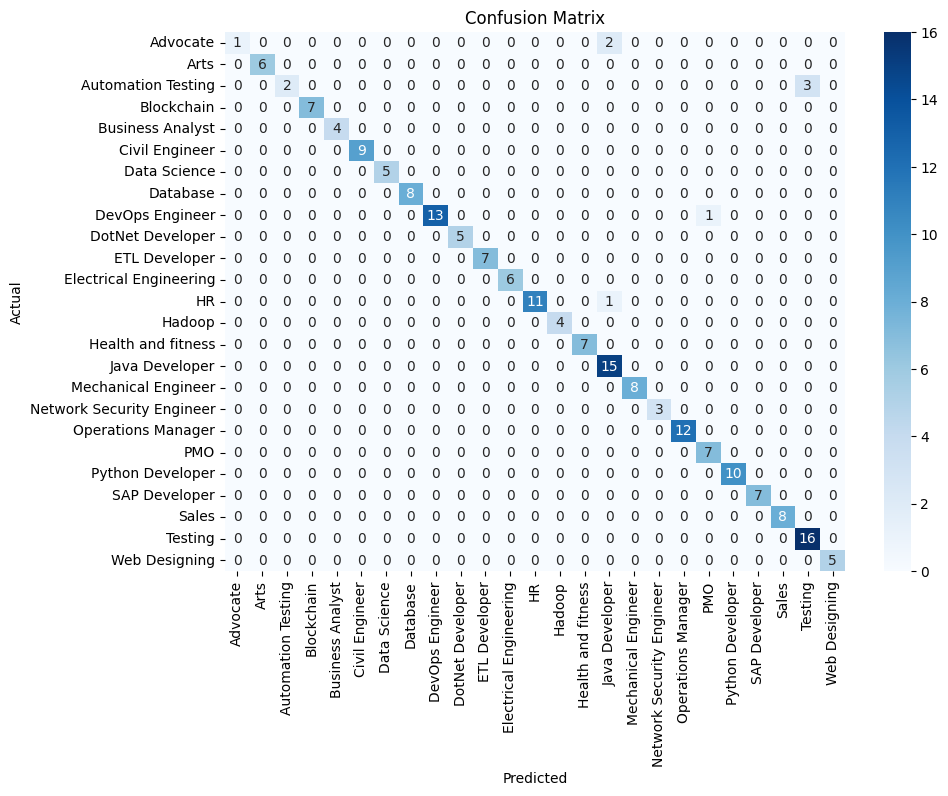

In [21]:
plot_confusion_matrix(y_test, predictions, labels=model.classes_)


In [22]:
def extract_text_from_pdf(pdf_path):
    text = ''
    with open(pdf_path, 'rb') as pdf_file:
        reader = PyPDF2.PdfReader(pdf_file)
        for page_num in range(len(reader.pages)):
            page = reader.pages[page_num]
            text += page.extract_text()
    return text

def calculate_ats_score(job_description, resume_text):
    job_keywords = set(re.findall(r'\b\w+\b', job_description.lower()))
    resume_keywords = set(re.findall(r'\b\w+\b', resume_text.lower()))

    matched_keywords = job_keywords.intersection(resume_keywords)
    ats_score = len(matched_keywords) / len(job_keywords) * 100  # percentage

    return ats_score

In [23]:
job_description = """
Seeking a Web Developer proficient in React.js and React Native to build scalable web and mobile applications. Must have experience with modern JavaScript frameworks and responsive design
"""

In [24]:
import pickle

# Save the trained model to a pickle file
filename = 'resume_category_model.pkl'
pickle.dump(model, open(filename, 'wb'))

print(f"Model saved to {filename}")

Model saved to resume_category_model.pkl


In [26]:
from pathlib import Path

uploaded_pdf_filename = "Shubham Kumar.pdf"
candidates = [
    Path.cwd() / "ml_pipline" / "sample_data" / uploaded_pdf_filename,
    Path.cwd() / "sample_data" / uploaded_pdf_filename,
    Path("ml_pipline") / "sample_data" / uploaded_pdf_filename,
    Path("sample_data") / uploaded_pdf_filename,
]

uploaded_pdf_path = None
for c in candidates:
    if c.exists():
        uploaded_pdf_path = c
        break

# fallback: search workspace for the file name
if uploaded_pdf_path is None:
    for p in Path.cwd().rglob("*.pdf"):
        if p.name == uploaded_pdf_filename:
            uploaded_pdf_path = p
            break

if uploaded_pdf_path is None:
    raise FileNotFoundError(f"PDF not found: {uploaded_pdf_filename}. Searched: {candidates} and subdirectories")

# process the found PDF
resume_text = extract_text_from_pdf(str(uploaded_pdf_path))
cleaned_resume = cleanResume(resume_text)
vectorized_resume = tfidf.transform([cleaned_resume])
prediction = model.predict(vectorized_resume)
print(f"Predicted Category: {prediction[0]}")

Predicted Category: Java Developer


In [27]:
prediction = model.predict(vectorized_resume)
print(f"Predicted Category: {prediction[0]}")

Predicted Category: Java Developer


In [28]:
ats_score = calculate_ats_score(job_description, cleaned_resume)
print(f"ATS Score: {ats_score:.2f}%")

ATS Score: 33.33%


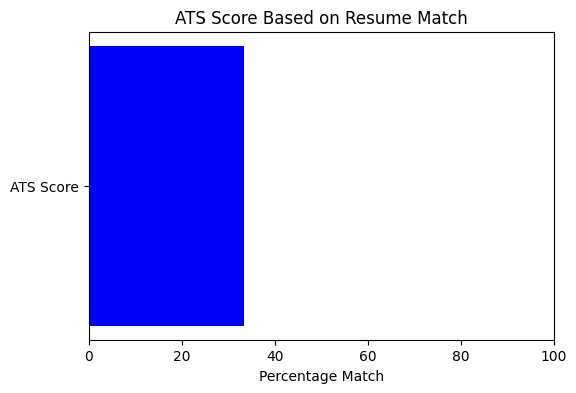

In [29]:
def plot_ats_score(ats_score):
    plt.figure(figsize=(6, 4))
    plt.barh(['ATS Score'], [ats_score], color='blue')
    plt.xlim(0, 100)
    plt.title('ATS Score Based on Resume Match')
    plt.xlabel('Percentage Match')
    plt.show()

plot_ats_score(ats_score)

ATS Score: 33.33%


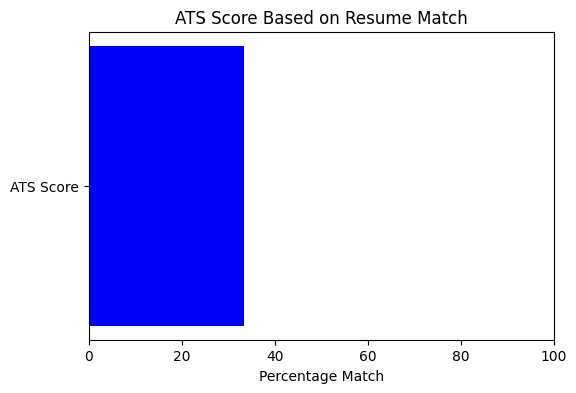

In [30]:
if os.path.exists(str(uploaded_pdf_path)):
    ats_score = calculate_ats_score(job_description, cleaned_resume)
    print(f"ATS Score: {ats_score:.2f}%")
    plot_ats_score(ats_score)
else:
    print(f"File not found at {uploaded_pdf_path}")